In [1]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit.opflow import X, Z, I
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
opt = SLSQP(maxiter=10000)
vqe = VQE(ansatz=ansatz, optimizer=opt, quantum_instance=ql, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(H2_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 65,
    'eigenstate': array([ 9.54998859e-05+2.98234338e-16j, -9.93766275e-01-7.35755577e-16j,
        1.11483549e-01+2.60562039e-16j,  1.77240156e-05+7.05233587e-17j]),
    'eigenvalue': (-1.8572750175659285+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[4]): -2.5983258651155454,
                              ParameterVectorElement(θ[6]): -4.717618122820399,
                              ParameterVectorElement(θ[5]): 1.5683259885445988,
                              ParameterVectorElement(θ[7]): 0.36020722970466373,
                              ParameterVectorElement(θ[3]): 6.092947776896387,
                              ParameterVectorElement(θ[1]): 4.426962084521693,
                              ParameterVectorElement(θ[2]): 0.5470753589336304,
                              ParameterVectorElement(θ[0]): 4.296520309146017},
    'optimal_point': array([ 4.29652031,  4.42696208,  0.54707536,  6.09294778, -

In [24]:
from scipy.linalg import expm
import numpy.linalg as LA
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Y, Z, I
def create_hamiltonian(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))
    
    for k in range(0, Nq):
        '''
        隣あうqubitのみ相互作用するようなモデルを考える
        0 1 2 ... k-1 X X k+2 ... N-1
        0 1 2 ... k-1 Y Y k+2 ... N-1
        '''
        
        # 端まで計算したらスキップ
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    return XX + YY + Zn

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from math import pi
def create_ansatz(q,cn,r,bn):
    theta = Parameter('θ')
    time = Parameter('t')
#     TODO: boundを設定できるか確認
    qc = QuantumCircuit(q)    
    qc.rx(theta,[0,1])
    qc.ry(theta,[0,1])
    hami = expm(-1j*create_hamiltonian(q,cn,r,bn)*1)
    qc.append(Operator(hami),list(range(q)))
    return qc


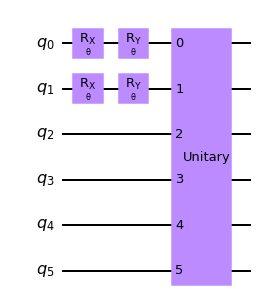

In [25]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

qubit = 6
cn = [1] * qubit
r = 0
bn = [0] * qubit

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = create_ansatz(qubit, cn, r, bn)
ansatz.draw('mpl')